In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input, MultiHeadAttention, Dropout, Concatenate,LayerNormalization
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from hydroeval import evaluator, nse

In [19]:
data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)
print(data)

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
01/01/2008        120        498.815         259.499               0.0   
02/01/2008        117        470.866         518.755               0.0   
03/01/2008        139        423.816         615.242               0.0   
04/01/2008        166        496.882         902.982               0.0   
05/01/2008        179        501.232        1072.970               0.0   
...               ...            ...             ...               ...   
27/12/2014        111        482.000         355.000             111.7   
28/12/2014        108        442.000         386.000              95.6   
29/12/2014         84        268.000         474.000             119.7   
30/12/2014         80        543.000         345.000             104.7   
31/12/2014         77        812.000         380.590             101.0   

            chayMayTuyenQuan  nuocVeT

In [20]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [21]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  # 'mucNuocHN' là cột đầu tiên
    return np.array(sequences), np.array(targets)


In [22]:
sequence_length = 10 # Sử dụng số ngày trước để dự báo ngày tiếp theo
X, y = create_sequences(data_scaled, sequence_length)

In [23]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(X_train.shape[1])

10


In [24]:
# LSTM lớp ẩn
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out = LSTM(64, activation='relu', return_sequences=True)(input_layer)
attention_out = MultiHeadAttention(num_heads=15, key_dim=64)(lstm_out, lstm_out)
# concat_output = Concatenate()([lstm_out, attention_out])
# Lớp Attention
dropout_layer = Dropout(0.1)(attention_out)
lstm_out_attention = LSTM(32)(dropout_layer)
# Lớp đầu ra
output = Dense(1)(lstm_out_attention)


In [25]:
# Khởi tạo và biên dịch mô hình
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10, 7)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 10, 64)               18432     ['input_2[0][0]']             
                                                                                                  
 multi_head_attention_1 (Mu  (None, 10, 64)               248704    ['lstm_2[0][0]',              
 ltiHeadAttention)                                                   'lstm_2[0][0]']              
                                                                                                  
 dropout_1 (Dropout)         (None, 10, 64)               0         ['multi_head_attention_1

In [26]:
# 3. Huấn luyện mô hình
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Dừng nếu không cải thiện sau 10 epochs
    restore_best_weights=True
)
history = model.fit(X_train,y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping],verbose=1,
    shuffle=True)

Epoch 1/50
64/64 [==============================] - 7s 40ms/step - loss: 0.0085 - val_loss: 0.0059
Epoch 2/50
64/64 [==============================] - 2s 29ms/step - loss: 0.0040 - val_loss: 0.0059
Epoch 3/50
64/64 [==============================] - 2s 27ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 4/50
64/64 [==============================] - 2s 29ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 5/50
64/64 [==============================] - 2s 26ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 6/50
64/64 [==============================] - 2s 28ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/50
64/64 [==============================] - 2s 33ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/50
64/64 [==============================] - 2s 31ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 9/50
64/64 [==============================] - 2s 33ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 10/50
64/64 [==============================] - 3s 45ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/

In [27]:
# def nse(y_true, y_pred):
#     return 1 - sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2)

In [28]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R² (R-squared):", r2)

# Tính NSE
nse_value = evaluator(nse,y_test.flatten(), y_pred.flatten())
print("Nash-Sutcliffe Efficiency (NSE):", nse_value[0])

# Tính MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

16/16 [==============================] - 1s 12ms/step
R² (R-squared): 0.9671494687538691
Nash-Sutcliffe Efficiency (NSE): 0.9664322491329297
Mean Absolute Error (MAE): 0.01675405875145982
Root Mean Squared Error (RMSE): 0.021962283946575914


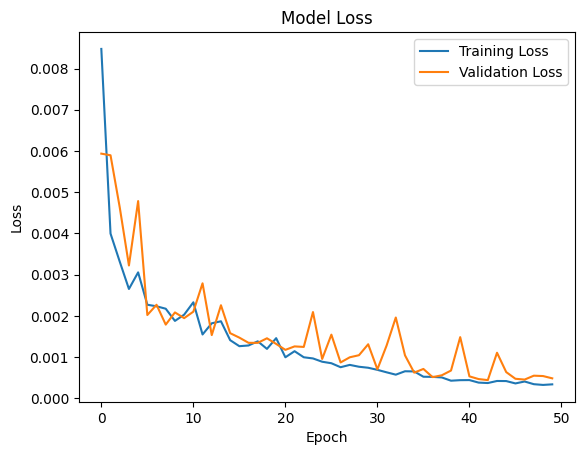

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
new_data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
new_data['Ngay'] = pd.to_datetime(new_data['Ngay'], format='%d/%m/%Y')
new_data.set_index('Ngay', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(new_data)

In [31]:
dates = new_data.columns
print(dates)

Index(['mucNuocHN', 'nuocVeHoaBinh', 'chayMayHoaBinh', 'nuocVeTuyenQuang',
       'chayMayTuyenQuan', 'nuocVeThacBa', 'chayMayThacBa'],
      dtype='object')


In [32]:
new_data_scaled = scaler.transform(new_data)  # Sử dụng scaler đã huấn luyện từ dữ liệu ban đầu

# Chia dữ liệu mới thành chuỗi thời gian
X_test_new, y_test_new = create_sequences(new_data_scaled, sequence_length)
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], X_test_new.shape[2]))

predictions_new = model.predict(X_test_new)
num_columns = new_data_scaled.shape[1]
print(num_columns)
predictions_new_original = scaler.inverse_transform(
    np.concatenate((predictions_new, np.zeros((predictions_new.shape[0], num_columns - predictions_new.shape[1]))), axis=1)
)[:, 0]

# Thêm đủ các cột phụ vào y_test_new để khớp với số cột của scaler
y_test_new_original = scaler.inverse_transform(
    np.concatenate((y_test_new.reshape(-1, 1), np.zeros((y_test_new.shape[0], num_columns - 1))), axis=1)
)[:, 0]

23/23 [==============================] - 0s 10ms/step
7


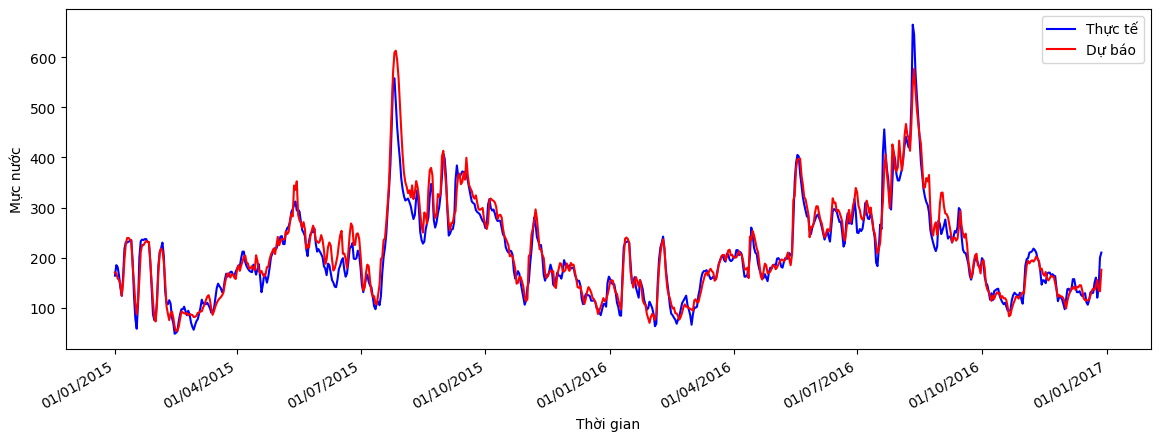

In [33]:
# Đảm bảo các mảng có cùng kích thước
import matplotlib.dates as mdates 
min_length = min(len(new_data.index), len(y_test_new_original), len(predictions_new_original))

# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = new_data.index[:min_length]
y_test_new_original = y_test_new_original[:min_length]
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


In [34]:
# Tạo mảng ngày bắt đầu từ chỉ số sequence_length của new_data
dates = new_data.index[sequence_length:]

# Đảm bảo số lượng phần tử của dự báo và thực tế khớp với số lượng ngày
min_length = min(len(dates), len(predictions_new_original), len(y_test_new_original))

# Cắt ngắn các mảng để khớp số phần tử nếu cần
dates = dates[:min_length]
predictions_new_original = predictions_new_original[:min_length]
y_test_new_original = y_test_new_original[:min_length]

# Tạo DataFrame với ngày, thực tế và dự báo
df_mucNuocHN = pd.DataFrame({
    'Ngay': dates,
    'ThucTe': y_test_new_original,
    'DuBao': predictions_new_original
})

# Đặt cột 'Ngay' làm chỉ mục
df_mucNuocHN.set_index('Ngay', inplace=True)

# Đặt tên đa cấp cho các cột với nhóm 'mucNuocHaNoi'
df_mucNuocHN.columns = pd.MultiIndex.from_product([['mucNuocHaNoi'], ['ThucTe', 'DuBao']])

# Hiển thị DataFrame
print(df_mucNuocHN)


           mucNuocHaNoi            
                 ThucTe       DuBao
Ngay                               
2015-01-11        164.0  170.663616
2015-01-12        185.0  168.326194
2015-01-13        181.0  158.476819
2015-01-14        164.0  155.075713
2015-01-15        140.0  146.409038
...                 ...         ...
2017-01-03        160.0  143.659098
2017-01-04        120.0  155.275904
2017-01-05        140.0  134.406663
2017-01-06        200.0  132.845905
2017-01-07        210.0  175.804018

[728 rows x 2 columns]
